### Import packages

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns

### Load data

In [33]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [34]:
##Check the dimensions of the datasets
print('Shape of train is',train_data.shape)
print('Shape of test is',test_data.shape)

Shape of train is (7160, 14)
Shape of test is (3069, 13)


In [35]:
### check first 5 rows of train data to check that we have the correct data
train_data.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [36]:
## check column types
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
Customer Id           7160 non-null object
YearOfObservation     7160 non-null int64
Insured_Period        7160 non-null float64
Residential           7160 non-null int64
Building_Painted      7160 non-null object
Building_Fenced       7160 non-null object
Garden                7153 non-null object
Settlement            7160 non-null object
Building Dimension    7054 non-null float64
Building_Type         7160 non-null int64
Date_of_Occupancy     6652 non-null float64
NumberOfWindows       7160 non-null object
Geo_Code              7058 non-null object
Claim                 7160 non-null int64
dtypes: float64(3), int64(4), object(7)
memory usage: 783.2+ KB


### EDA

Let us explore the dataset to see if there are some important features or those that need to be dropped.

In [37]:
#Check how many years of data we have
train_data['YearOfObservation'].value_counts()

2012    1858
2013    1811
2014    1373
2015    1075
2016    1043
Name: YearOfObservation, dtype: int64

In [38]:
# check how balanced the dataset is
train_data['Claim'].value_counts()

0    5526
1    1634
Name: Claim, dtype: int64

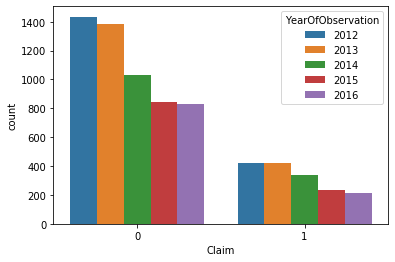

In [39]:
# Can we combine the above metrics in a single plot?
sns.countplot(x='Claim', data=train_data, hue ='YearOfObservation')

In [40]:
pd.pivot_table(train_data,index = ['Residential'], values = 'Customer Id', columns=['Claim'],aggfunc='count')

Claim,0,1
Residential,,
0,3926,1047
1,1600,587


Most buildings are non-residential. Of those that are residential, almost 40% of them claimed for insurance.

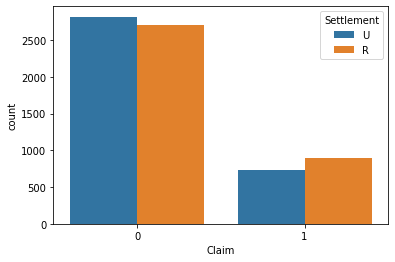

In [41]:
sns.countplot(x='Claim', data=train_data, hue ='Settlement')

There is no big difference between the rural and urban settlement but we can still see that of those who claimed for insurance, the rural were leading.

### Data Pre-processing

In [42]:
#separate the target variable from independent variables
y_train = train_data['Claim']

train_data.drop('Claim',axis=1,inplace=True)

#combine the datasets for preprocessing
combined_data = pd.concat([train_data,test_data],axis=0)
combined_data.shape

(10229, 13)

#### Missing values

In [43]:
#check how many missing values are  there in each column
combined_data.isnull().sum()

Customer Id              0
YearOfObservation        0
Insured_Period           0
Residential              0
Building_Painted         0
Building_Fenced          0
Garden                  11
Settlement               0
Building Dimension     119
Building_Type            0
Date_of_Occupancy     1236
NumberOfWindows          0
Geo_Code               115
dtype: int64

There are 4 variables with missing values. Only one has extremely many missing values.

In [44]:
#fill missing values with mode value
combined_data['Garden'].fillna(combined_data['Garden'].mode()[0],inplace=True)

In [45]:
#fill missing values with None
combined_data['Date_of_Occupancy'].fillna('None',inplace=True)

In [46]:
#fill missing values with mean
combined_data['Building Dimension'].fillna(combined_data['Building Dimension'].mean(),inplace=True)

In [47]:
#fill missing values with mode value
combined_data['Geo_Code'].fillna(combined_data['Geo_Code'].mode()[0],inplace=True)

In [48]:
#replace  . in the NumberOfWindows with None since it means they are missing value
combined_data['NumberOfWindows'].replace(('   .'), 'None', inplace=True)

In [49]:
#confirm there are no missing values 
combined_data.isnull().sum()

Customer Id           0
YearOfObservation     0
Insured_Period        0
Residential           0
Building_Painted      0
Building_Fenced       0
Garden                0
Settlement            0
Building Dimension    0
Building_Type         0
Date_of_Occupancy     0
NumberOfWindows       0
Geo_Code              0
dtype: int64

### Feature Engineering

In this section we look for the best features and we also convert the variables to a format that our model can understand. We start by dropping some columns that are not useful in th model and then we proceed to covert categorical features to numerical.

In [50]:
combined_data['Geo_Code']

0       1053
1       1053
2       1053
3       1053
4       1053
        ... 
3064    6088
3065    6088
3066    6088
3067    6088
3068    6088
Name: Geo_Code, Length: 10229, dtype: object

In [51]:
#drop ID column
combined_data.drop(columns=['Geo_Code','Customer Id'], axis=1 ,inplace=True)

In [52]:
#apply label encoding to Geo_code
#combined_data["Geo_Code"] = combined_data["Geo_Code"].astype('category').cat.codes

#get categorical columns
cat_cols = combined_data.dtypes[combined_data.dtypes=='object'].index

#apply one-hot encoding to categorical features
combined_data_converted = pd.get_dummies(data=combined_data, columns=cat_cols)

#check new shape of the data
combined_data_converted.shape

(10229, 164)

In [53]:
#split the data back into train and test
x_train = combined_data_converted.iloc[:len(train_data)]
x_test = combined_data_converted.iloc[len(train_data):]

### Model building

In [54]:
#Create a cross-validation function
n_folds = 5
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

def accuracy_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train.values)
    accuracy= cross_val_score(model, x_train.values, y_train, scoring="accuracy", cv = kf)
    return accuracy

In [55]:
#We start off by a logistic regressor
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=101, solver='liblinear')

In [56]:
score = accuracy_cv(log_reg)
print("Logistic regression score: {:.4f} ".format(score.mean()))

Logistic regression score: 0.7838 


In [57]:
#fit the model
log_reg.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=101, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [58]:
#make predictions
predictions = log_reg.predict(x_test)

In [59]:
#count number of claims and no claims
np.asarray(np.unique(predictions,return_counts=True)).T

array([[   0, 2942],
       [   1,  127]])

### Stacking different Models

In [60]:
from vecstack import stacking 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

ModuleNotFoundError: No module named 'xgboost'

In [61]:
models = [
    KNeighborsClassifier(n_neighbors=5,
                        n_jobs=-1),
    
    LogisticRegression(random_state=0,solver='liblinear'),
    
    RandomForestClassifier(random_state=0, n_jobs=-1, 
                           n_estimators=400, max_depth=3),
        
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.01, 
                  n_estimators=400, max_depth=3)
]

NameError: name 'XGBClassifier' is not defined

In [62]:
Staked_train, Stacked_test = stacking(models,                   
                           x_train, y_train, x_test,   
                           regression=False, 
     
                           mode='oof_pred_bag', 
       
                           needs_proba=False,
         
                           save_dir=None, 
            
                           metric=accuracy_score, 
    
                           n_folds=5, 
                 
                           stratified=True,
            
                           shuffle=True,  
            
                           random_state=0,    
         
                           verbose=2)

NameError: name 'models' is not defined

In [63]:
model = XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.01, 
                      n_estimators=400, max_depth=3)
    
model = model.fit(Staked_train, y_train)
y_pred = model.predict(Stacked_test)

NameError: name 'XGBClassifier' is not defined

In [64]:
#convert the predictions to pandas dataframe
submission = pd.DataFrame(data={'Customer Id':test_data['Customer Id'],'Claim':y_pred})

NameError: name 'y_pred' is not defined

In [65]:
submission.Claim.value_counts()

NameError: name 'submission' is not defined

In [66]:
#export to csv
submission.to_csv('Submission.csv',index=False)

NameError: name 'submission' is not defined